# HW 1: League of Legends Win Prediction

## Dmytro Romaniv 151958

---

### Problem Statement
Given early-game statistics from a League of Legends match (first 10 minutes), predict whether the **blue side** wins the game.

- **Task Type:** Binary Classification
- **Target:** `blueWins` (1 if blue side wins, 0 otherwise)
- **Dataset:** [League of Legends Diamond Ranked Games (10 min)](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min)


<a id="1"></a>
## 1. Environment Setup & Installation

Install and import all required libraries. Set random seeds for reproducibility.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report
)

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

# Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback

# Weights & Biases
import wandb

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed, workers=True)
    
set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

PyTorch version: 2.9.0+cu126
PyTorch Lightning version: 2.5.6
Optuna version: 3.3.0
CUDA available: True


Seed set to 42


<a id="2"></a>
## 2. Data Loading & Exploration

Load the League of Legends dataset and perform initial exploration.

In [2]:
# Load the dataset
# Download from: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min
# Place the CSV file in the 'data' folder

data_path = 'data/high_diamond_ranked_10min.csv'

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Check if file exists
if not os.path.exists(data_path):
    print(f"Dataset not found at {data_path}")
else:
    print(f"Dataset found at {data_path}")

# Load data
df = pd.read_csv(data_path)

print(f"\nDataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
print("\n" + "="*70)


Dataset found at data/high_diamond_ranked_10min.csv

Dataset Shape: (9879, 40)
   Rows: 9,879, Columns: 40



In [3]:
# Display first few rows
print("First 5 rows of the dataset:\n")
df.head()


First 5 rows of the dataset:



,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
# Dataset information
print("Dataset Info:\n")
print(df.info())
print("\n" + "="*70)


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   i

In [5]:
# Check for missing values
print("Missing Values:\n")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found")
else:
    print(missing[missing > 0])
print("\n" + "="*70)


Missing Values:

No missing values found



In [6]:
# Statistical summary
print("Statistical Summary:\n")
df.describe()


Statistical Summary:



,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


Target Variable Distribution:

blueWins
0    4949
1    4930
Name: count, dtype: int64

Class Balance:
  Blue Wins (1): 49.90%
  Blue Loses (0): 50.10%


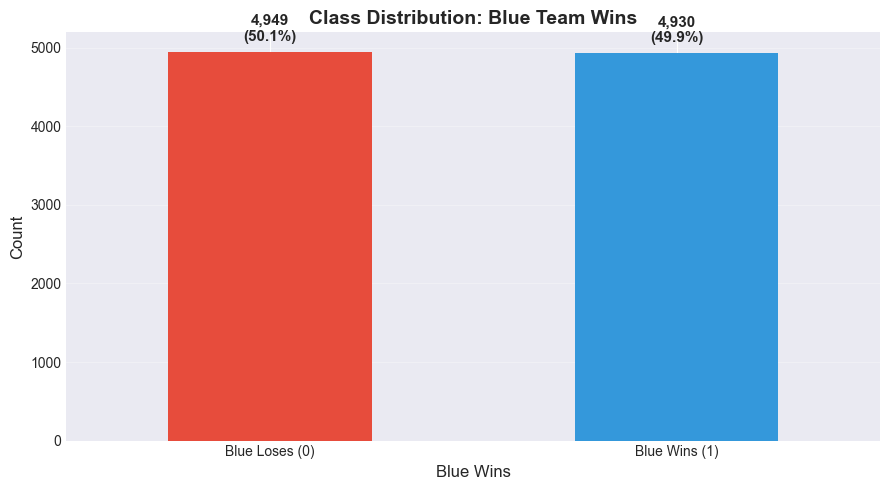

In [7]:
# Class distribution
print("Target Variable Distribution:\n")
target_counts = df['blueWins'].value_counts()
print(target_counts)
print(f"\nClass Balance:")
print(f"  Blue Wins (1): {target_counts[1] / len(df) * 100:.2f}%")
print(f"  Blue Loses (0): {target_counts[0] / len(df) * 100:.2f}%")

# Visualize class distribution
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
target_counts.plot(kind='bar', ax=ax, color=['#E74C3C', '#3498DB'])
ax.set_title('Class Distribution: Blue Team Wins', fontsize=14, fontweight='bold')
ax.set_xlabel('Blue Wins', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['Blue Loses (0)', 'Blue Wins (1)'], rotation=0)
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(target_counts):
    ax.text(i, v + 100, f'{v:,}\n({v/len(df)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)


<a id="3"></a>
## 3. Data Preprocessing & Feature Engineering

Select relevant early-game features and normalize them.

In [8]:
# Feature selection - using ONLY early-game (10 min) statistics
# Exclude gameId and blueWins (target)

print("Feature Engineering\n")

# List all columns
print("All columns in dataset:")
print(df.columns.tolist())
print("\n" + "="*70)

# Select features (all except gameId and blueWins)
feature_cols = [col for col in df.columns if col not in ['gameId', 'blueWins']]

print(f"\nSelected {len(feature_cols)} features for training:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)


Feature Engineering

All columns in dataset:
['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']


Selected 38 features for training:
   1. blueWardsPlaced
   2. blueWardsDestroyed
   3. blueFirstBlood
   4. blueKills
   5. blueDeaths
   6. blueAssists
   7. blueEliteMonsters
   8. blueDragons
   9. blueHeralds
  10. blueTow

In [9]:
# Prepare feature matrix X and target vector y
X = df[feature_cols].values
y = df['blueWins'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature matrix dtype: {X.dtype}")
print(f"Target vector dtype: {y.dtype}")
print("\n" + "="*70)


Feature matrix shape: (9879, 38)
Target vector shape: (9879,)

Feature matrix dtype: float64
Target vector dtype: int64



<a id="4"></a>
## 4. Train/Validation/Test Split

Split the dataset using stratified sampling to maintain class balance.

In [10]:
# Split data: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% of temp for validation, 50% for test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Data Split Summary:\n")
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTotal:          {len(X):,} samples")

# Check class balance in splits
print("\nClass Distribution in Splits:\n")
print(f"Training:   Blue Wins = {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"Validation: Blue Wins = {y_val.sum() / len(y_val) * 100:.2f}%")
print(f"Test:       Blue Wins = {y_test.sum() / len(y_test) * 100:.2f}%")
print("\n" + "="*70)


Data Split Summary:

Training set:   6,915 samples (70.0%)
Validation set: 1,482 samples (15.0%)
Test set:       1,482 samples (15.0%)

Total:          9,879 samples

Class Distribution in Splits:

Training:   Blue Wins = 49.91%
Validation: Blue Wins = 49.93%
Test:       Blue Wins = 49.87%



In [11]:
# Normalize features using StandardScaler
# Fit on training data, transform all splits
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Features normalized using StandardScaler")
print(f"\nTraining set statistics after normalization:")
print(f"  Mean: {X_train.mean():.6f}")
print(f"  Std:  {X_train.std():.6f}")
print("\n" + "="*70)


Features normalized using StandardScaler

Training set statistics after normalization:
  Mean: 0.000000
  Std:  1.000000



<a id="5"></a>
## 5. PyTorch Dataset Implementation

Custom Dataset class for League of Legends match data.

In [12]:
class LolDataset(Dataset):
    """
    Custom PyTorch Dataset for League of Legends match data.
    
    Args:
        features (np.ndarray): Feature matrix (samples x features)
        labels (np.ndarray): Target labels (samples,)
    """
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Test the dataset
train_dataset = LolDataset(X_train, y_train)
val_dataset = LolDataset(X_val, y_val)
test_dataset = LolDataset(X_test, y_test)

print("PyTorch Datasets created successfully\n")
print(f"Training dataset:   {len(train_dataset):,} samples")
print(f"Validation dataset: {len(val_dataset):,} samples")
print(f"Test dataset:       {len(test_dataset):,} samples")

# Test retrieval
sample_features, sample_label = train_dataset[0]
print(f"\nSample data point:")
print(f"  Features shape: {sample_features.shape}")
print(f"  Features dtype: {sample_features.dtype}")
print(f"  Label: {sample_label.item()}")
print("\n" + "="*70)


PyTorch Datasets created successfully

Training dataset:   6,915 samples
Validation dataset: 1,482 samples
Test dataset:       1,482 samples

Sample data point:
  Features shape: torch.Size([38])
  Features dtype: torch.float32
  Label: 1.0



<a id="6"></a>
## 6. PyTorch Lightning DataModule

Wraps datasets and dataloaders using Lightning's DataModule pattern.

In [13]:
class LolDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule for League of Legends data.
    
    Handles data loading and batching for train/val/test splits.
    
    Args:
        X_train, X_val, X_test: Feature matrices
        y_train, y_val, y_test: Target labels
        batch_size: Batch size for dataloaders
        num_workers: Number of workers for data loading
    """
    
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, 
                 batch_size=256, num_workers=0):
        super().__init__()
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def setup(self, stage=None):
        """Create datasets for each split."""
        self.train_dataset = LolDataset(self.X_train, self.y_train)
        self.val_dataset = LolDataset(self.X_val, self.y_val)
        self.test_dataset = LolDataset(self.X_test, self.y_test)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=self.num_workers
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers
        )

print("LolDataModule class defined successfully")
print("\n" + "="*70)


LolDataModule class defined successfully



In [14]:
# Test the DataModule
test_dm = LolDataModule(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=256)
test_dm.setup()

# Get a batch from train loader
train_loader = test_dm.train_dataloader()
batch_features, batch_labels = next(iter(train_loader))

print("DataModule test successful\n")
print(f"Batch features shape: {batch_features.shape}")
print(f"Batch labels shape:   {batch_labels.shape}")
print(f"Features dtype:       {batch_features.dtype}")
print(f"Labels dtype:         {batch_labels.dtype}")
print(f"\nNumber of batches:")
print(f"  Training:   {len(train_loader)} batches")
print(f"  Validation: {len(test_dm.val_dataloader())} batches")
print(f"  Test:       {len(test_dm.test_dataloader())} batches")
print("\n" + "="*70)


DataModule test successful

Batch features shape: torch.Size([256, 38])
Batch labels shape:   torch.Size([256])
Features dtype:       torch.float32
Labels dtype:         torch.float32

Number of batches:
  Training:   28 batches
  Validation: 6 batches
  Test:       6 batches



<a id="7"></a>
## 7. PyTorch Lightning Model (LightningModule)

Define the MLP model with PyTorch Lightning hooks.

In [15]:
class LolWinPredictor(pl.LightningModule):
    """
    PyTorch Lightning Module for predicting LoL match outcomes.
    
    Multi-layer perceptron (MLP) with configurable architecture.
    
    Args:
        input_dim: Number of input features
        hidden_dim: Size of hidden layers
        num_layers: Number of hidden layers
        dropout: Dropout rate
        learning_rate: Learning rate for optimizer
    """
    
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.learning_rate = learning_rate
        
        # Build MLP layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
        # Loss function
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self, x):
        """Forward pass - returns logits."""
        return self.model(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        """Training step - compute loss and log metrics."""
        features, labels = batch
        logits = self(features)
        loss = self.criterion(logits, labels)
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step - compute loss and accuracy."""
        features, labels = batch
        logits = self(features)
        loss = self.criterion(logits, labels)
        
        # Compute predictions
        preds = (torch.sigmoid(logits) > 0.5).float()
        acc = (preds == labels).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def test_step(self, batch, batch_idx):
        """Test step - same as validation."""
        features, labels = batch
        logits = self(features)
        loss = self.criterion(logits, labels)
        
        preds = (torch.sigmoid(logits) > 0.5).float()
        acc = (preds == labels).float().mean()
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        
        return {'test_loss': loss, 'test_acc': acc}
    
    def configure_optimizers(self):
        """Configure optimizer."""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

print("LolWinPredictor class defined successfully")
print("\n" + "="*70)


LolWinPredictor class defined successfully



In [16]:
# Test the model with a forward pass
input_dim = X_train.shape[1]

test_model = LolWinPredictor(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3,
    learning_rate=1e-3
)

# Test forward pass
test_input = torch.randn(32, input_dim)
test_output = test_model(test_input)

print("Model forward pass test successful\n")
print(f"Model architecture:")
print(test_model)
print(f"\nTest input shape:  {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"Output dtype:      {test_output.dtype}")
print("\n" + "="*70)


Model forward pass test successful

Model architecture:
LolWinPredictor(
  (model): Sequential(
    (0): Linear(in_features=38, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (criterion): BCEWithLogitsLoss()
)

Test input shape:  torch.Size([32, 38])
Test output shape: torch.Size([32])
Output dtype:      torch.float32



<a id="8"></a>
## 8. Monitoring Setup (Weights & Biases)

Configure WandB logger and callbacks for experiment tracking.

In [17]:
def create_logger_and_callbacks(run_name, config=None, patience=5):
    """
    Create WandB logger and Lightning callbacks.
    
    Args:
        run_name: Name for the WandB run
        config: Hyperparameter configuration dict
        patience: Early stopping patience
        
    Returns:
        logger: WandbLogger instance
        callbacks: List of Lightning callbacks
    """
    
    logger = WandbLogger(
        project="lol-win-prediction",
        name=run_name,
        config=config,
        log_model=False
    )
    
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename=f'{run_name}-{{epoch:02d}}-{{val_acc:.4f}}',
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        verbose=True
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        verbose=True
    )
    
    callbacks = [checkpoint_callback, early_stop_callback]
    
    return logger, callbacks


<a id="9"></a>
## 9. Baseline Training Run

Train a baseline model with hand-picked hyperparameters.

In [18]:
baseline_config = {
    'hidden_dim': 64,
    'num_layers': 1,
    'dropout': 0.5,
    'learning_rate': 1e-2,
    'batch_size': 128,
    'max_epochs': 15
}

print("Baseline Configuration:")
for key, value in baseline_config.items():
    print(f"  {key:15s}: {value}")
print("\n" + "="*70)

Baseline Configuration:
  hidden_dim     : 64
  num_layers     : 1
  dropout        : 0.5
  learning_rate  : 0.01
  batch_size     : 128
  max_epochs     : 15



In [19]:
# Create DataModule with baseline batch size
baseline_dm = LolDataModule(
    X_train, X_val, X_test, y_train, y_val, y_test,
    batch_size=baseline_config['batch_size']
)

# Create baseline model
baseline_model = LolWinPredictor(
    input_dim=input_dim,
    hidden_dim=baseline_config['hidden_dim'],
    num_layers=baseline_config['num_layers'],
    dropout=baseline_config['dropout'],
    learning_rate=baseline_config['learning_rate']
)

# Create logger and callbacks
baseline_logger, baseline_callbacks = create_logger_and_callbacks(
    run_name='baseline',
    config=baseline_config
)

# Create trainer
baseline_trainer = pl.Trainer(
    max_epochs=baseline_config['max_epochs'],
    logger=baseline_logger,
    callbacks=baseline_callbacks,
    accelerator='auto',
    devices=1,
    deterministic=True,
    enable_progress_bar=True
)

print("Baseline trainer configured")
print("\nStarting baseline training...")
print("="*70)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Baseline trainer configured

Starting baseline training...


In [20]:
# Train the baseline model
baseline_trainer.fit(baseline_model, baseline_dm)

print("\nBaseline training complete")
print("="*70)


wandb: Currently logged in as: dromaniv (dromaniv-n-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 2.6 K  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, v_num=4m0i, val_loss=0.546, val_acc=0.715, train_loss=0.551]

Metric val_loss improved. New best score: 0.546
Epoch 0, global step 55: 'val_acc' reached 0.71457 (best 0.71457), saving model to 'C:\\Users\\dmrom\\mops\\project1\\checkpoints\\baseline-epoch=00-val_acc=0.7146.ckpt' as top 1


Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 66.20it/s, v_num=4m0i, val_loss=0.548, val_acc=0.721, train_loss=0.545]

Epoch 1, global step 110: 'val_acc' reached 0.72132 (best 0.72132), saving model to 'C:\\Users\\dmrom\\mops\\project1\\checkpoints\\baseline-epoch=01-val_acc=0.7213.ckpt' as top 1


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 66.42it/s, v_num=4m0i, val_loss=0.543, val_acc=0.718, train_loss=0.541]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.543
Epoch 2, global step 165: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 66.23it/s, v_num=4m0i, val_loss=0.542, val_acc=0.715, train_loss=0.542]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.542
Epoch 3, global step 220: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 69.03it/s, v_num=4m0i, val_loss=0.547, val_acc=0.713, train_loss=0.541]

Epoch 4, global step 275: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 69.04it/s, v_num=4m0i, val_loss=0.545, val_acc=0.717, train_loss=0.540]

Epoch 5, global step 330: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 65.93it/s, v_num=4m0i, val_loss=0.540, val_acc=0.716, train_loss=0.543]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.540
Epoch 6, global step 385: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 67.81it/s, v_num=4m0i, val_loss=0.542, val_acc=0.717, train_loss=0.547]

Epoch 7, global step 440: 'val_acc' was not in top 1


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 69.97it/s, v_num=4m0i, val_loss=0.542, val_acc=0.717, train_loss=0.542]

Epoch 8, global step 495: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 64.93it/s, v_num=4m0i, val_loss=0.544, val_acc=0.717, train_loss=0.545]

Epoch 9, global step 550: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 68.50it/s, v_num=4m0i, val_loss=0.547, val_acc=0.717, train_loss=0.539]

Epoch 10, global step 605: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 66.76it/s, v_num=4m0i, val_loss=0.548, val_acc=0.717, train_loss=0.542]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.540. Signaling Trainer to stop.
Epoch 11, global step 660: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 66.01it/s, v_num=4m0i, val_loss=0.548, val_acc=0.717, train_loss=0.542]

Baseline training complete


In [21]:
# Display baseline results
print("Baseline Model Results:\n")

# Get best checkpoint path
best_checkpoint = baseline_callbacks[0].best_model_path
print(f"Best checkpoint: {best_checkpoint}")

# Get metrics from trainer
if hasattr(baseline_trainer, 'callback_metrics'):
    metrics = baseline_trainer.callback_metrics
    print(f"\nFinal metrics:")
    if 'val_loss' in metrics:
        print(f"  Validation Loss:     {metrics['val_loss']:.4f}")
    if 'val_acc' in metrics:
        print(f"  Validation Accuracy: {metrics['val_acc']:.4f}")

# Close WandB run
wandb.finish()

print("\n" + "="*70)


Baseline Model Results:

Best checkpoint: C:\Users\dmrom\mops\project1\checkpoints\baseline-epoch=01-val_acc=0.7213.ckpt

Final metrics:
  Validation Loss:     0.5485
  Validation Accuracy: 0.7173


epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
train_loss,█▅▂▂▂▂▄▆▃▅▁▃
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
val_acc,▃█▅▃▁▄▄▄▅▅▄▅
val_loss,▆█▃▃▇▅▁▂▃▄▇█
epoch,11
train_loss,0.54173
trainer/global_step,659
val_acc,0.71727
val_loss,0.5485


<a id="10"></a>
## 10. Hyperparameter Optimization with Optuna

Use Optuna to find optimal hyperparameters.

In [22]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Best validation accuracy achieved during training
    """
    
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 5e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    
    dm = LolDataModule(
        X_train, X_val, X_test, y_train, y_val, y_test,
        batch_size=batch_size
    )
    
    model = LolWinPredictor(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        learning_rate=learning_rate
    )
    
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor='val_acc')
    
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints/optuna',
        filename=f'trial_{trial.number}-{{epoch:02d}}-{{val_acc:.4f}}',
        monitor='val_acc',
        mode='max',
        save_top_k=1
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min'
    )
    
    trainer = pl.Trainer(
        max_epochs=25,
        callbacks=[pruning_callback, checkpoint_callback, early_stop_callback],
        accelerator='auto',
        devices=1,
        logger=False,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(model, dm)
    
    return checkpoint_callback.best_model_score.item()

print("Optuna objective function defined")
print("\nHyperparameter search space:")
print("  - hidden_dim:     [64, 128, 256, 512]")
print("  - num_layers:     [1, 2, 3, 4, 5]")
print("  - dropout:        [0.1, 0.5]")
print("  - learning_rate:  [5e-5, 5e-3] (log scale)")
print("  - batch_size:     [128, 256, 512]")
print("\n" + "="*70)

Optuna objective function defined

Hyperparameter search space:
  - hidden_dim:     [64, 128, 256, 512]
  - num_layers:     [1, 2, 3, 4, 5]
  - dropout:        [0.1, 0.5]
  - learning_rate:  [5e-5, 5e-3] (log scale)
  - batch_size:     [128, 256, 512]



In [23]:
# Create Optuna study
study = optuna.create_study(
    direction='maximize',  # Maximize validation accuracy
    study_name='lol-win-prediction',
    sampler=optuna.samplers.TPESampler(seed=42)
)

print("Starting hyperparameter optimization...")
print("This may take a while depending on n_trials...")
print("="*70 + "\n")

# Run optimization
N_TRIALS = 30

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*70)
print("Hyperparameter optimization complete")
print("="*70)


[I 2025-11-10 13:24:50,908] A new study created in memory with name: lol-win-prediction


Starting hyperparameter optimization...
This may take a while depending on n_trials...



  0%|          | 0/30 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Best trial: 0. Best value: 0.723347:   3%|▎         | 1/30 [00:09<04:28,  9.27s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:00,183] Trial 0 finished with value: 0.7233468294143677 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.16239780813448107, 'learning_rate': 6.533369619026643e-05, 'batch_size': 128}. Best is trial 0 with value: 0.7233468294143677.


Best trial: 1. Best value: 0.724696:   7%|▋         | 2/30 [00:14<03:09,  6.76s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:05,189] Trial 1 finished with value: 0.7246963381767273 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.17336180394137352, 'learning_rate': 0.00020298058052421552, 'batch_size': 128}. Best is trial 1 with value: 0.7246963381767273.


Best trial: 1. Best value: 0.724696:  10%|█         | 3/30 [00:23<03:30,  7.79s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:14,198] Trial 2 finished with value: 0.7213225364685059 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.41407038455720546, 'learning_rate': 0.00012540578430226165, 'batch_size': 256}. Best is trial 1 with value: 0.7246963381767273.


Best trial: 3. Best value: 0.730769:  13%|█▎        | 4/30 [00:29<03:10,  7.33s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:20,825] Trial 3 finished with value: 0.7307692170143127 and parameters: {'hidden_dim': 512, 'num_layers': 5, 'dropout': 0.4233589392465845, 'learning_rate': 0.00020332816567573966, 'batch_size': 256}. Best is trial 3 with value: 0.7307692170143127.


Best trial: 3. Best value: 0.730769:  17%|█▋        | 5/30 [00:32<02:19,  5.58s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:23,300] Trial 4 finished with value: 0.7253711223602295 and parameters: {'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.36500891374159283, 'learning_rate': 0.00021008360271862668, 'batch_size': 256}. Best is trial 3 with value: 0.7307692170143127.


Best trial: 3. Best value: 0.730769:  20%|██        | 6/30 [00:32<01:30,  3.79s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:23,611] Trial 5 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  23%|██▎       | 7/30 [00:35<01:16,  3.35s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:26,050] Trial 6 finished with value: 0.7273954153060913 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.31707843326329943, 'learning_rate': 9.567940243846155e-05, 'batch_size': 512}. Best is trial 3 with value: 0.7307692170143127.


Best trial: 3. Best value: 0.730769:  27%|██▋       | 8/30 [00:40<01:27,  3.99s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:31,408] Trial 7 finished with value: 0.7240216135978699 and parameters: {'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.3916028672163949, 'learning_rate': 0.001743856312272965, 'batch_size': 256}. Best is trial 3 with value: 0.7307692170143127.


Best trial: 3. Best value: 0.730769:  30%|███       | 9/30 [00:41<01:06,  3.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:32,821] Trial 8 pruned. Trial was pruned at epoch 3.


Best trial: 3. Best value: 0.730769:  33%|███▎      | 10/30 [00:42<00:49,  2.46s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:33,653] Trial 9 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  37%|███▋      | 11/30 [00:45<00:50,  2.68s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:36,852] Trial 10 finished with value: 0.7240216135978699 and parameters: {'hidden_dim': 512, 'num_layers': 5, 'dropout': 0.48781484431514643, 'learning_rate': 0.0036605866216263072, 'batch_size': 256}. Best is trial 3 with value: 0.7307692170143127.


Best trial: 3. Best value: 0.730769:  40%|████      | 12/30 [00:46<00:35,  1.97s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:37,193] Trial 11 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  43%|████▎     | 13/30 [00:46<00:24,  1.47s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:37,497] Trial 12 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  47%|████▋     | 14/30 [00:46<00:17,  1.12s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:37,812] Trial 13 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  50%|█████     | 15/30 [00:47<00:13,  1.14it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:38,132] Trial 14 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  53%|█████▎    | 16/30 [00:47<00:10,  1.31it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:38,632] Trial 15 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  57%|█████▋    | 17/30 [00:48<00:08,  1.58it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:38,958] Trial 16 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  60%|██████    | 18/30 [00:48<00:06,  1.87it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:39,269] Trial 17 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  63%|██████▎   | 19/30 [00:48<00:05,  1.91it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:39,761] Trial 18 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  67%|██████▋   | 20/30 [00:49<00:05,  1.86it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:40,331] Trial 19 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  70%|███████   | 21/30 [00:49<00:04,  2.12it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:40,655] Trial 20 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  73%|███████▎  | 22/30 [00:50<00:03,  2.22it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:41,051] Trial 21 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  77%|███████▋  | 23/30 [00:50<00:03,  2.28it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:41,459] Trial 22 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  80%|████████  | 24/30 [00:50<00:02,  2.39it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:41,835] Trial 23 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  83%|████████▎ | 25/30 [00:51<00:02,  2.39it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:42,252] Trial 24 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  87%|████████▋ | 26/30 [00:51<00:01,  2.32it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:42,710] Trial 25 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  90%|█████████ | 27/30 [00:52<00:01,  2.41it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:43,091] Trial 26 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  93%|█████████▎| 28/30 [00:52<00:00,  2.36it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:43,533] Trial 27 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769:  97%|█████████▋| 29/30 [00:53<00:00,  2.05it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-10 13:25:44,172] Trial 28 pruned. Trial was pruned at epoch 0.


Best trial: 3. Best value: 0.730769: 100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

[I 2025-11-10 13:25:44,469] Trial 29 pruned. Trial was pruned at epoch 0.

Hyperparameter optimization complete


In [24]:
# Display best trial results
print("\nBest Trial Results:\n")
print(f"  Trial number:      {study.best_trial.number}")
print(f"  Validation Accuracy: {study.best_value:.4f}")

print("\nBest Hyperparameters:\n")
best_params = study.best_params
for key, value in best_params.items():
    print(f"  {key:15s}: {value}")

print("\n" + "="*70)



Best Trial Results:

  Trial number:      3
  Validation Accuracy: 0.7308

Best Hyperparameters:

  hidden_dim     : 512
  num_layers     : 5
  dropout        : 0.4233589392465845
  learning_rate  : 0.00020332816567573966
  batch_size     : 256



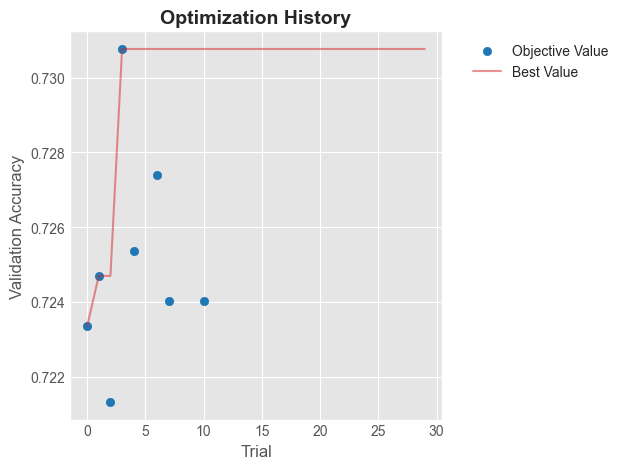

<Figure size 700x500 with 0 Axes>

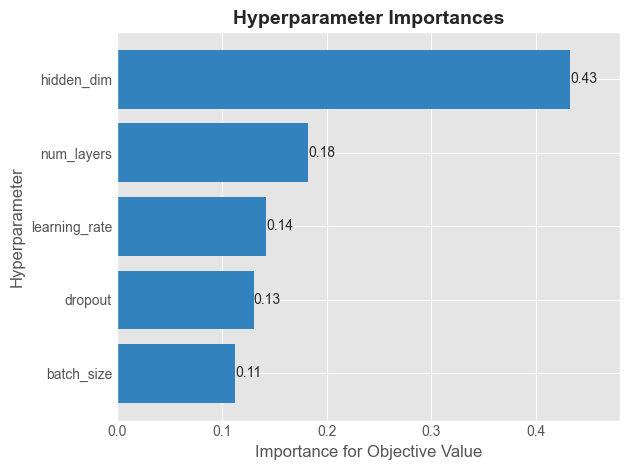

In [25]:
# Optimization history
ax1 = optuna.visualization.matplotlib.plot_optimization_history(study)
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.set_xlabel('Trial', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontsize=12)
plt.tight_layout()
plt.show()

# Parameter importances
plt.figure(figsize=(7, 5))
try:
    ax2 = optuna.visualization.matplotlib.plot_param_importances(study)
    ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')
except Exception:
    ax2 = plt.gca()
    ax2.text(
        0.5, 0.5,
        'Not enough trials\nfor importance analysis',
        ha='center', va='center', fontsize=12
    )
    ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

<a id="11"></a>
## 11. Best Model Training & Evaluation

Retrain with best hyperparameters and evaluate on test set.

In [26]:
best_config = {
    'hidden_dim': best_params['hidden_dim'],
    'num_layers': best_params['num_layers'],
    'dropout': best_params['dropout'],
    'learning_rate': best_params['learning_rate'],
    'batch_size': best_params['batch_size'],
    'max_epochs': 50
}

print("Best Configuration (from Optuna):")
for key, value in best_config.items():
    print(f"  {key:15s}: {value}")
print("\n" + "="*70)

Best Configuration (from Optuna):
  hidden_dim     : 512
  num_layers     : 5
  dropout        : 0.4233589392465845
  learning_rate  : 0.00020332816567573966
  batch_size     : 256
  max_epochs     : 50



In [27]:
best_dm = LolDataModule(
    X_train, X_val, X_test, y_train, y_val, y_test,
    batch_size=best_config['batch_size']
)

best_model = LolWinPredictor(
    input_dim=input_dim,
    hidden_dim=best_config['hidden_dim'],
    num_layers=best_config['num_layers'],
    dropout=best_config['dropout'],
    learning_rate=best_config['learning_rate']
)

best_logger, best_callbacks = create_logger_and_callbacks(
    run_name='best_model',
    config=best_config,
    patience=10
)

best_trainer = pl.Trainer(
    max_epochs=best_config['max_epochs'],
    logger=best_logger,
    callbacks=best_callbacks,
    accelerator='auto',
    devices=1,
    deterministic=True,
    enable_progress_bar=True
)

print("Best model trainer configured")
print("\nStarting training with best hyperparameters...")
print("="*70)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Best model trainer configured

Starting training with best hyperparameters...


In [28]:
# Train the best model
best_trainer.fit(best_model, best_dm)

print("\nBest model training complete")
print("="*70)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 1.1 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.284     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 28/28 [00:00<00:00, 50.70it/s, v_num=202w, val_loss=0.547, val_acc=0.726, train_loss=0.647]

Metric val_loss improved. New best score: 0.547
Epoch 0, global step 28: 'val_acc' reached 0.72605 (best 0.72605), saving model to 'C:\\Users\\dmrom\\mops\\project1\\checkpoints\\best_model-epoch=00-val_acc=0.7260.ckpt' as top 1


Epoch 1: 100%|██████████| 28/28 [00:00<00:00, 49.68it/s, v_num=202w, val_loss=0.540, val_acc=0.723, train_loss=0.546]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.540
Epoch 1, global step 56: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 28/28 [00:00<00:00, 48.54it/s, v_num=202w, val_loss=0.539, val_acc=0.723, train_loss=0.540]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.539
Epoch 2, global step 84: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 28/28 [00:00<00:00, 49.64it/s, v_num=202w, val_loss=0.540, val_acc=0.721, train_loss=0.537]

Epoch 3, global step 112: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 28/28 [00:00<00:00, 48.90it/s, v_num=202w, val_loss=0.540, val_acc=0.723, train_loss=0.535]

Epoch 4, global step 140: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 28/28 [00:00<00:00, 45.38it/s, v_num=202w, val_loss=0.539, val_acc=0.724, train_loss=0.533]

Epoch 5, global step 168: 'val_acc' was not in top 1


Epoch 6: 100%|██████████| 28/28 [00:00<00:00, 48.52it/s, v_num=202w, val_loss=0.541, val_acc=0.720, train_loss=0.534]

Epoch 6, global step 196: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 28/28 [00:00<00:00, 49.71it/s, v_num=202w, val_loss=0.541, val_acc=0.723, train_loss=0.534]

Epoch 7, global step 224: 'val_acc' was not in top 1


Epoch 8: 100%|██████████| 28/28 [00:00<00:00, 50.02it/s, v_num=202w, val_loss=0.548, val_acc=0.721, train_loss=0.537]

Epoch 8, global step 252: 'val_acc' was not in top 1


Epoch 9: 100%|██████████| 28/28 [00:00<00:00, 49.95it/s, v_num=202w, val_loss=0.540, val_acc=0.723, train_loss=0.536]

Epoch 9, global step 280: 'val_acc' was not in top 1


Epoch 10: 100%|██████████| 28/28 [00:00<00:00, 49.92it/s, v_num=202w, val_loss=0.539, val_acc=0.716, train_loss=0.529]

Epoch 10, global step 308: 'val_acc' was not in top 1


Epoch 11: 100%|██████████| 28/28 [00:00<00:00, 50.79it/s, v_num=202w, val_loss=0.539, val_acc=0.720, train_loss=0.532]

Epoch 11, global step 336: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 28/28 [00:00<00:00, 46.46it/s, v_num=202w, val_loss=0.542, val_acc=0.720, train_loss=0.529]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.539. Signaling Trainer to stop.
Epoch 12, global step 364: 'val_acc' was not in top 1


Epoch 12: 100%|██████████| 28/28 [00:00<00:00, 45.41it/s, v_num=202w, val_loss=0.542, val_acc=0.720, train_loss=0.529]

Best model training complete


In [29]:
# Evaluate on test set
print("Evaluating on test set...\n")

test_results = best_trainer.test(best_model, best_dm)

print("\nTest Set Results:")
print(f"  Test Loss:     {test_results[0]['test_loss']:.4f}")
print(f"  Test Accuracy: {test_results[0]['test_acc']:.4f}")

wandb.finish()

print("\n" + "="*70)


Evaluating on test set...



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 103.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7300944924354553
        test_loss           0.5212430953979492
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Test Set Results:
  Test Loss:     0.5212
  Test Accuracy: 0.7301


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
val_acc,█▆▆▅▆▇▄▆▄▆▁▄▄
val_loss,█▂▁▂▂▁▃▃█▂▂▂▄
epoch,13
test_acc,0.73009
test_loss,0.52124
train_loss,0.52943


In [30]:
# Get detailed predictions for confusion matrix and other metrics
best_model.eval()
best_model.to('cpu')

with torch.no_grad():
    test_features = torch.FloatTensor(X_test)
    test_logits = best_model(test_features)
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs > 0.5).float().numpy()

# Compute detailed metrics
test_acc = accuracy_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_probs.numpy())

print("Detailed Test Set Metrics:\n")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, test_preds, target_names=['Blue Loses', 'Blue Wins']))

print("="*70)


Detailed Test Set Metrics:

  Accuracy:  0.7301
  Precision: 0.7351
  Recall:    0.7172
  F1 Score:  0.7260
  ROC-AUC:   0.8189

Classification Report:

              precision    recall  f1-score   support

  Blue Loses       0.73      0.74      0.73       743
   Blue Wins       0.74      0.72      0.73       739

    accuracy                           0.73      1482
   macro avg       0.73      0.73      0.73      1482
weighted avg       0.73      0.73      0.73      1482



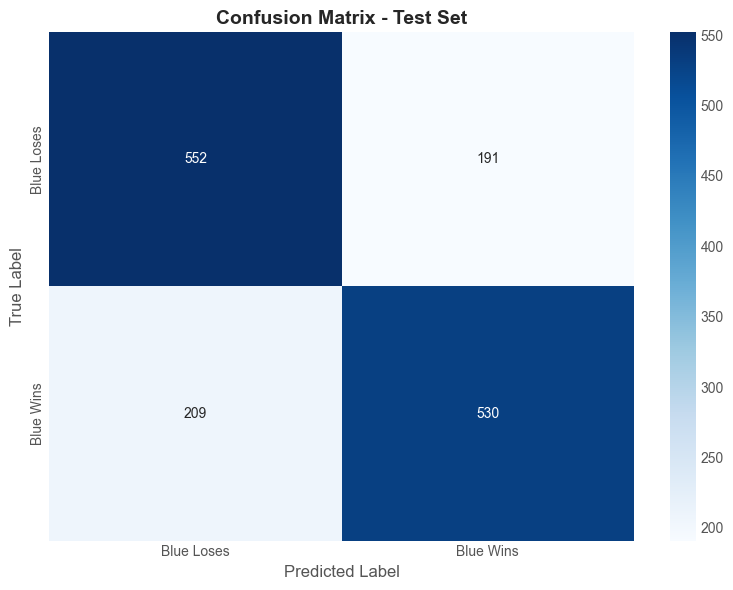

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Blue Loses', 'Blue Wins'],
            yticklabels=['Blue Loses', 'Blue Wins'])
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

<a id="12"></a>
## 12. Results Visualization & Analysis

Compare baseline vs optimized model performance.

In [32]:
print("="*70)
print("BASELINE vs OPTIMIZED MODEL COMPARISON")
print("="*70)

comparison_data = {
    'Metric': ['Hidden Dim', 'Num Layers', 'Dropout', 'Learning Rate', 'Batch Size'],
    'Baseline': [
        baseline_config['hidden_dim'],
        baseline_config['num_layers'],
        baseline_config['dropout'],
        f"{baseline_config['learning_rate']:.0e}",
        baseline_config['batch_size']
    ],
    'Optimized': [
        best_config['hidden_dim'],
        best_config['num_layers'],
        f"{best_config['dropout']:.3f}",
        f"{best_config['learning_rate']:.0e}",
        best_config['batch_size']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nHyperparameter Comparison:\n")
print(comparison_df.to_string(index=False))

BASELINE vs OPTIMIZED MODEL COMPARISON

Hyperparameter Comparison:

       Metric Baseline Optimized
   Hidden Dim       64       512
   Num Layers        1         5
      Dropout      0.5     0.423
Learning Rate    1e-02     2e-04
   Batch Size      128       256


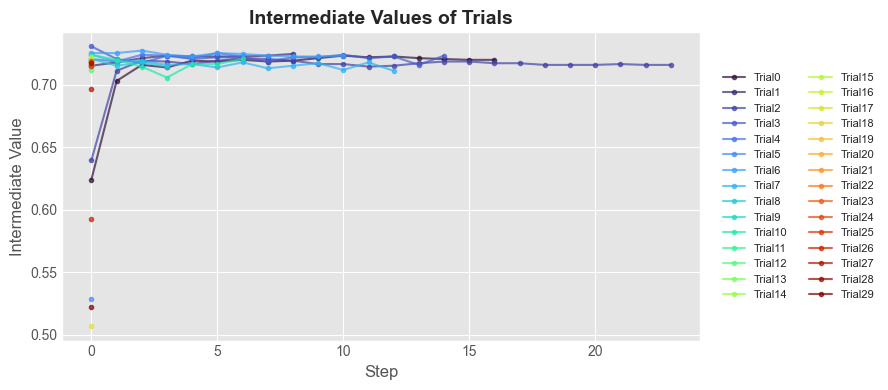

In [33]:
# plot first
ax = optuna.visualization.matplotlib.plot_intermediate_values(study)
fig = ax.get_figure()
fig.set_size_inches(9, 4)

# how many lines were drawn
lines = ax.get_lines()
m = len(lines)

# sample m unique colors from a continuous colormap
cmap   = mpl.cm.get_cmap('turbo', m)
colors = cmap(np.linspace(0, 1, m))

# apply colors to lines
for line, c in zip(lines, colors):
    line.set_color(c)

# rebuild legend so handles match the new colors
handles, labels = ax.get_legend_handles_labels()
for h, c in zip(handles, colors[:len(handles)]):
    h.set_color(c)
ax.legend(handles, labels, ncol=2, fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))

ax.set_title('Intermediate Values of Trials', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()


---

## Summary & Conclusions

### Requirements Fulfilled

1. **PyTorch Lightning**
   - Implemented `LightningModule` (LolWinPredictor)
   - Implemented `LightningDataModule` (LolDataModule)
   - Used Lightning `Trainer` for all training

2. **Custom Dataset & DataLoader**
   - Created `LolDataset` inheriting from `torch.utils.data.Dataset`
   - Wrapped in `LightningDataModule` with proper train/val/test loaders

3. **Model Monitoring**
   - Integrated Weights & Biases (WandB): [lol-win-prediction](https://wandb.ai/dromaniv-n-a/lol-win-prediction)
   - Logged training/validation metrics
   - Used ModelCheckpoint and EarlyStopping callbacks

4. **Hyperparameter Optimization**
   - Used Optuna with TPE sampler
   - Searched: hidden_dim, num_layers, dropout, learning_rate, batch_size
   - Improved validation accuracy over baseline

### Results

**Baseline Model Performance:**
```
Validation Accuracy: 71.73%
Validation Loss:     0.5485
```

**Optimized Model Performance (Trial 3):**
```
Validation Accuracy: 73.08%
Test Accuracy:       73.01%
Test Loss:           0.5212

Detailed Metrics:
  Precision: 0.7351
  Recall:    0.7172
  F1 Score:  0.7260
  ROC-AUC:   0.8189
```

**Best Hyperparameters Found:**
```
hidden_dim:     512
num_layers:     5
dropout:        0.423
learning_rate:  0.000203
batch_size:     256
```

**Improvement:**
- Validation accuracy improved by ~1.35% (71.73% → 73.08%)
- Larger network (512 vs 64 hidden units, 5 vs 1 layers)
- Lower dropout (0.423 vs 0.5) allowed better learning
- Much lower learning rate (0.0002 vs 0.01) for stable training
- Larger batch size (256 vs 128) for better gradient estimates

---

### Main Problems Encountered

**Problem 1: Class Imbalance**

Issue: Dataset is balanced (~49% wins), but minor imbalances can affect training.

Solution: Used stratified splitting to maintain class distribution across splits.

```python
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y
)
```

**Problem 2: Data Leakage Prevention**

Issue: Must ensure only early-game features (10 min) are used.

Solution: Excluded `gameId` and `blueWins` from features.

```python
feature_cols = [col for col in df.columns if col not in ['gameId', 'blueWins']]
```

**Problem 3: Overfitting**

Issue: MLP models can overfit on tabular data.

Solutions: Dropout layers (0.1-0.5), early stopping, validation monitoring.

```python
layers.append(nn.Dropout(dropout))
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')
```

**Problem 4: Hyperparameter Tuning Convergence**

Issue: Some hyperparameter combinations converge slowly or poorly.

Solutions: Optuna pruning, reduced epochs for trials (15 vs 25), log-scale learning rate sampling.

```python
pruning_callback = PyTorchLightningPruningCallback(trial, monitor='val_acc')
learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
```

**Problem 5: Feature Scaling**

Issue: Features have different scales (gold, kills, wards), hurting neural network training.

Solution: Applied StandardScaler, fit on train only, transform all splits.

```python
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
```